<a href="https://colab.research.google.com/github/warenya/OP-GSP-Image-Stitching/blob/main/TIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 必要なインポート :

In [ ]:
!pip install opencv-python-headless numpy scipy matplotlib
import cv2
import numpy as np
from scipy.optimize import minimize
import scipy.spatial
import scipy.interpolate
import matplotlib.pyplot as plt
import math

## オーバーラップ率の計算
グランドサンプリング距離、中心座標、2つ目の画像のField of Viewの頂点、オーバーラップ点、オーバーラップ率はこの関数で計算される。

点A、B、C、D、E、p1, p2, n1、n2, l1, l2 は次の画像に対応している：

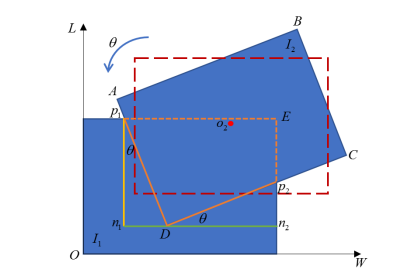

これは論文で提案されているオーバーラップ率計算アルゴリズムの実装ではあるが、今回の課題では直接使用しなかった。このアプローチは私のデータに矛盾を引き起こしたが、これは画像の角度、寸法、遠近法に起因する。



```
# オーバーラップ率を計算する関数
def overlap_ratio_calculation(image1, image2, h, f, pixel_size, row, col, lat1, lat2, lon1, lon2, uav_pos, R=6378000):
    # 地上サンプリング距離とFOVの計算
    GSD = (h * pixel_size) / f # GSD = h * a/f (Equation 9 in paper)
    w = GSD * col #width of a single image
    l = GSD * row #height of a single image

    # 中心座標の算出
    x0 = math.radians(R * math.cos(lat1) * (lon2 - lon1)) + (w / 2)
    y0 = math.radians(R * (lat2 - lat1)) + l / 2

     # UAVの向きをラジアンに変換
    theta = math.radians(uav_pos)

    # 同次座標を用いた回転変換
    # 変換行列（アフィン変換）
    rotation_matrix = np.array([
        [math.cos(theta), -math.sin(theta), (-x0 * math.cos(theta)) + (y0 * math.sin(theta)) + x0],
        [math.sin(theta),  math.cos(theta), (-x0 * math.sin(theta)) - (y0 * math.cos(theta)) + y0],
        [0, 0, 1]
    ])

    # 回転前の2つ目の画像のFOVの4隅のダミー値
    corners = np.array([
    [-w/2 + x0,  l/2 + y0,  1],  #頂点A(左上)
    [ w/2 + x0,  l/2 + y0,  1],  #頂点B(右上)
    [ w/2 + x0, -l/2 + y0,  1],  #頂点C (右下)
    [-w/2 + x0, -l/2 + y0,  1]   #頂点D (左下)
    ]).T

     # 変換を適用する
    transformed_corners = np.dot(rotation_matrix, corners)

   # 変換された座標を取り出す
    xA, yA = transformed_corners[0, 0], transformed_corners[1, 0]
    xB, yB = transformed_corners[0, 1], transformed_corners[1, 1]
    xC, yC = transformed_corners[0, 2], transformed_corners[1, 2]
    xD, yD = transformed_corners[0, 3], transformed_corners[1, 3]

     # オーバーラップ点p1とp2を計算する。
    p1_x = ((l - yD) * (xA - xD) / (yA - yD)) + xD
    p1_y = l
    p2_x = w
    p2_y = ((w - xD) / (xC - xD) * (yC - yD)) + yD

    #間のユークリッド距離：
    mag_p1E =  np.linalg.norm(np.array([p1_x, p1_y]) - np.array([w, l])) #P1 と E
    mag_p1n1 = np.linalg.norm(np.array([p1_x, p1_y]) - np.array([p1_x, yD])) #p1 と n1
    mag_p1D = np.linalg.norm(np.array([p1_x, p1_y]) - np.array([xD, yD])) #p1 と D
    mag_p2D = np.linalg.norm(np.array([p2_x, p2_y]) - np.array([xD, yD])) #p2 と D
    mag_Dn2 = np.linalg.norm(np.array([xD, yD]) - np.array([p2_x, yD])) #D と n2

    # Return オーバーラップ率
    overlap_ratio = ((mag_p1E * mag_p1n1) - (0.5 * mag_p1n1 * (mag_p1D * math.sin(theta)))
                    -(0.5 * mag_Dn2 * (mag_p2D * math.sin(theta)))) /(w * l)
    return overlap_ratio
```



## OP - GSPの前提条件

この関数はGSP実装のメッシュ辺を計算するために使用されます。メッシュ辺はGSPの相似項で使用されます。

In [ ]:
#ドロネー三角測量でメッシュのエッジを作る
def create_mesh_edges(pts):
  '''
    provides accurate results because a single edge belongs to the boundary if it's
    not shared between 2 triangles

  '''
  triangulation = scipy.spatial.Delaunay(pts)
  edges = set()
  for simplex in triangulation.simplices:
      for i in range(3):
          j = (i + 1) % 3
          edge = tuple(sorted([simplex[i], simplex[j]]))
          edges.add(edge)
  return list(edges)

##フィーチャーマッチング
この論文では特徴マッチング・アルゴリズムが明記されていないが、私はORBよりもSIFTを使用した。ORBの方が速いとはいえ、精度の方が優先されるからだ。私のテストデータは非常に小さい。従って、どちらかのアルゴリズムを使っても大きな利点はない。
    
これはOP-GSP法のステップ2であり、1つの画像からの特徴が2つ目の画像と比較され、マッチングされる。
#
```
//-- ロウ比テスト**
   {
        if (knn_matches[i][0].distance < ratio_thresh * knn_matches[i][1].distance)
        {
            good_matches.push_back(knn_matches[i][0]);
        }
    }


In [ ]:
def feature_matching(img1, img2):
  '''

    2つの画像間の特徴をマッチさせ、特定された共通の特徴を可視化する
    SIFTを用いて

  '''
  # SIFTを開始し、キーポイントと記述子を見つける
  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # BFMatcherとNORM_L2をSIFTに使う
  # NORM_L2 はユークリッド距離に基づいて特徴点間の最も近い一致を見つけるため使用されました。
  # ユークリッド距離に基づいて特徴点間の最も近い一致を見つけるからです。
  bf = cv2.BFMatcher(cv2.NORM_L2)

  # KNN を用いた記述子のマッチング
  knn_matches = bf.knnMatch(des1, des2, k=2)

  # 正確な縫製のために、ロウの比率テストを適用し、良いマッチングを絞り込む。
  good_matches = []
  for m, n in knn_matches:
      if m.distance < 0.75 * n.distance:
          good_matches.append(m)

  if len(good_matches) < 10:
      print("Not enough good matches found.")
      return None, kp1, kp2, [], None, []

  # 一致したキーポイントを抽出する
  src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
  dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
  edges = create_mesh_edges(src_pts)

  optimized_vertices = optimize_GSP(src_pts, edges, desired_scale=1.0, desired_rotation=np.pi/6)

  # RANSACを使ってホモグラフィーを計算する
  H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

  if H is None:
      print("Homography computation failed.")
      return None, kp1, kp2, [], None, []

  inliers = mask.ravel().tolist()

  matchesMask = [m for i, m in enumerate(good_matches) if inliers[i]]

  img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matchesMask, None, singlePointColor=(255, 255, 255))

  return img_matches, kp1, kp2, matchesMask, H, inliers

##GSPモデル

GSPモデルには、アライメント項、局所的類似性項、大域的類似性項、そしてこれら3つを結合するエネルギー関数が含まれる。

In [ ]:
#GSPモデルのエネルギー項の計算
def global_similarity_term(vertices, edges, scale, rotation, beta=1.0):
    term = 0
    for (i, j) in edges:
        v_i, v_j = vertices[i], vertices[j]
        original_diff = v_i - v_j

        # 変換行列
        rotation_matrix = np.array([[np.cos(rotation), -np.sin(rotation)],
                                    [np.sin(rotation),  np.cos(rotation)]])
        transformed_diff = scale * np.dot(rotation_matrix, original_diff)

        term += beta * np.linalg.norm(original_diff - transformed_diff)**2

    return term


# GSPモデルの局所類似項
def local_similarity_term(vertices, edges, alpha=1.0):
    term = 0
    for (i, j) in edges:
        v_i, v_j = vertices[i], vertices[j]
        term += alpha * np.linalg.norm(v_i - v_j) ** 2

    return term

# GSPのアライメント用語
def alignment_term(vertices, original_vertices, lambda_align=1.0):
    return lambda_align * np.sum(np.linalg.norm(vertices - original_vertices, axis=1) ** 2)

# GSPの最適化用語
def optimize_GSP(vertices, edges, desired_scale, desired_rotation, alpha=1.0, lambda_align=1.0):
    """
    Optimize vertex positions using GSP, local similarity, and alignment constraints.
    """
    original_vertices = vertices.copy()

    def energy_function(V_flat):
        V = V_flat.reshape(-1, 2)
        return (global_similarity_term(V, edges, desired_scale, desired_rotation) +
                local_similarity_term(V, edges, alpha) +
                alignment_term(V, original_vertices, lambda_align))

    # 最適化のために初期頂点を平らにする
    initial_guess = vertices.flatten()

    result = minimize(energy_function, initial_guess, method='L-BFGS-B')

    # 元の構造に戻す
    optimized_vertices = result.x.reshape(vertices.shape)

    return optimized_vertices

##マッチしたキーポイントを描く

" Good "マッチしたキーポイントは、次の関数を使って描画される。

In [ ]:
# 新しい画像のコーナーを計算し、新しいフレームにワープさせる。
def combine_images(img1, img2, H):
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    corners_img2 = np.array([[0, 0], [width2-1, 0],
                             [width2-1, height2-1],
                             [0, height2-1]], dtype='float32')
    corners_img2 = np.array([corners_img2])

    warped_corners = cv2.perspectiveTransform(corners_img2, H)

    # つなぎ合わせた画像の寸法を求める
    min_x = min(warped_corners[0][:, 0].min(), 0)
    max_x = max(warped_corners[0][:, 0].max(), width1)
    min_y = min(warped_corners[0][:, 1].min(), 0)
    max_y = max(warped_corners[0][:, 1].max(), height1)

    output_width = int(max_x - min_x)
    output_height = int(max_y - min_y)

    translation_matrix = np.array([[1, 0, -min_x],
                                   [0, 1, -min_y],
                                   [0, 0, 1]], dtype='float32')
    H_translated = translation_matrix.dot(H)

    result_img = cv2.warpPerspective(img2, translation_matrix, (output_width, output_height))
    img1_warped = cv2.warpPerspective(img1, H_translated, (output_width, output_height))

    # 画像をブレンドする(OP-GSPの論文で提案されているような, 高度なオーバーラップ比を用いないシンプルなブレンド)
    # OP-GSP論文で提案されている)
    # img2が0でないピクセルを置き換える
    mask1 = result_img > 0
    mask2 = img1_warped > 0
    result_img[mask2] = img1_warped[mask2]

    return result_img

##主な機能
これは、座標データに実際のデータではなくダミーの値を使用しているためである。しかし、最初の図に見られるように、特徴点は正確にマッチングされている。


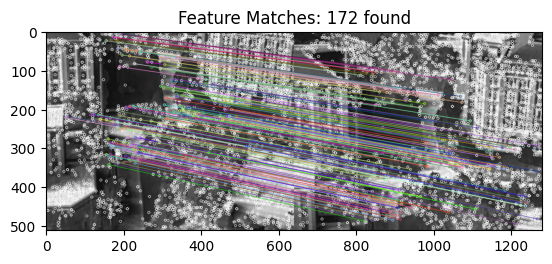

Matched image saved as output_matched_image.jpg


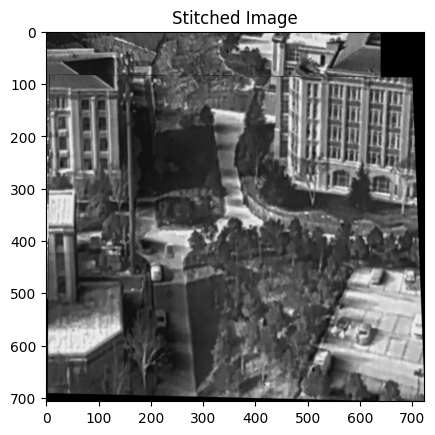

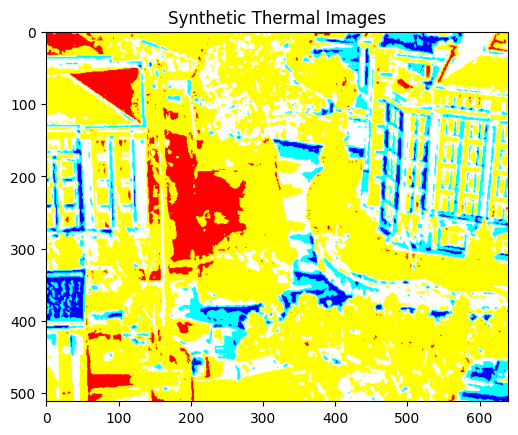

In [ ]:
def main():
    # サンプル画像を読み込む（データセットから連続した番号の画像を使う）
    img1 = cv2.imread("/0032.jpg", cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread("/0033.jpg", cv2.COLOR_BGR2GRAY)

    # 画像が正しく読み込まれるようにする
    if img1 is None or img2 is None:
        print("Error: Images not found.")
        return

    thermal_img1 = cv2.applyColorMap(img1, cv2.COLORMAP_JET)
    thermal_img2 = cv2.applyColorMap(img2, cv2.COLORMAP_JET)
    heat_intensity = np.random.normal(3, 0.3, img1.shape)
    thermal_img1 = np.multiply(thermal_img1, heat_intensity[:, :, np.newaxis])
    thermal_img2 = np.multiply(thermal_img2, heat_intensity[:, :, np.newaxis])

    # ステップ2：フィーチャーマッチング
    img_matches, kp1, kp2, matches, H, inliers = feature_matching(img1, img2)

    if H is None:
        print("Feature matching failed or homography computation unsuccessful.")
        return

   # マッチしたキーポイントを表示する
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f"Feature Matches: {len(matches)} found")
    plt.show()

    cv2.imwrite("output_matched_image.jpg", img_matches)
    print("Matched image saved as output_matched_image.jpg")

    stitched_image = combine_images(img1, img2, H)

  # つなぎ合わせた画像を表示する
    plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
    plt.title("Stitched Image")
    plt.show()

  # 赤外線画像を表示
    plt.imshow(thermal_img1)
    plt.imshow(thermal_img2)
    plt.title("Synthetic Thermal Images")
    plt.show()

if __name__ == "__main__":
    main()